# 2nd set of exercises

These exercises are designed for those of you that already have experience with ML / deep learning, and want to apply this knowledge to do some interesting NLP applications.

We'll be focusing mostly on word embeddings, with a bit of TF-IDF at the beginning to get your feet wet.

## 0. Requirements

Run the cell below to install dependencies.

In [ ]:
!pip install scikit-learn

## 1. A simple search engine

One of the simplest topics that one could choose for showing the popularity and potential of word embeddings is the humble search engine. We'll be vectorizing some documents. You've probably seen this in the first set of exercises, if not, no big deal! You're going to learn how to do it now!

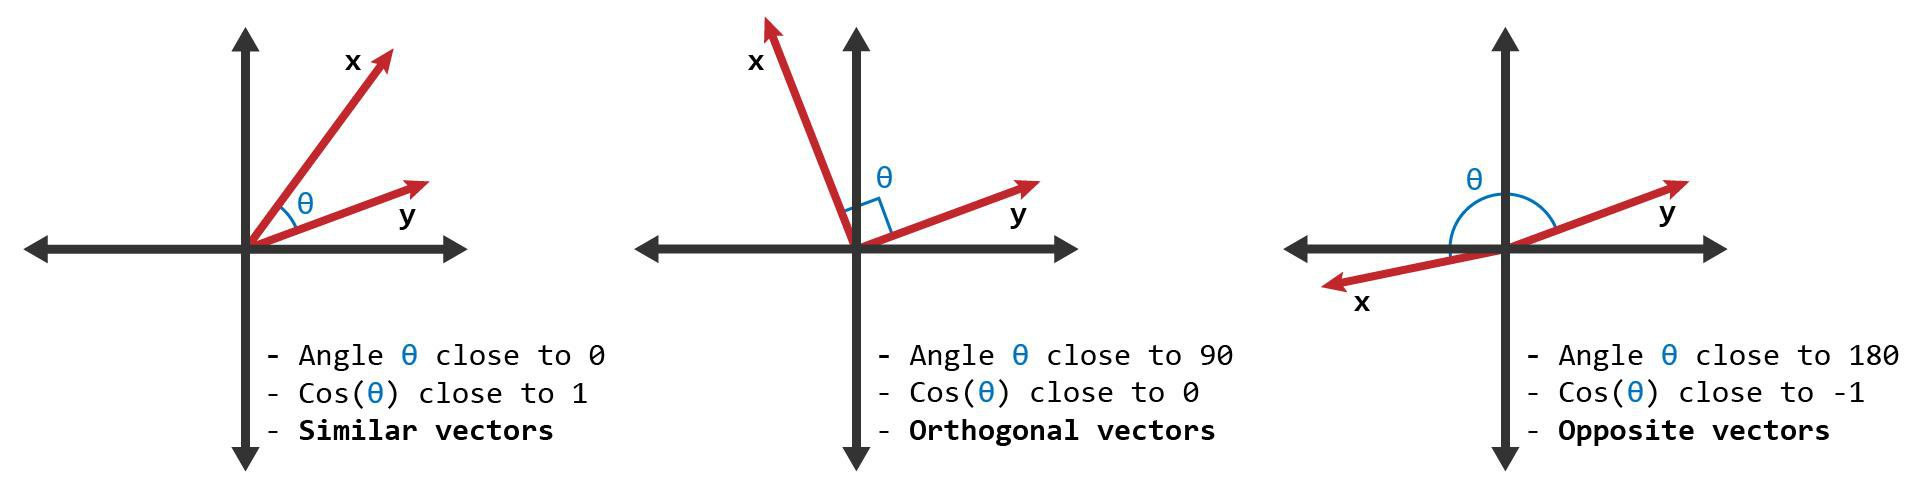

To not go over the nitty-gritty details of the implementation, we'll be using two tools that are already available to us in the scikit-learn package.

```py
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
```

- `TfidfVectorizer` - allows you to train on a corpus of documents, and obtain their TF-IDF representation for future use.
- `cosine_similarity` - utility function that takes two vectors and returns a floating point number between -1 and 1. This is what we'll use to decide which documents are "closer" to the query.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
class SimpleSearchEngine:
    """
    Initializes itself based on a corpus of documents and allows you to search for the top N documents closer to a query passed in.
    """
    def __init__(self, documents):
        self.documents = documents
        self.vectorizer = TfidfVectorizer()

        # Fit TF-IDF vectorizer on documents
        # YOUR CODE HERE
        self.tf_idf_matrix = self.vectorizer.fit_transform(documents)

    def search(self, query, top_n=5):
        # Transform query into TF-IDF representation
        query_vector = self.vectorizer.transform([query])
        
        # Compute cosine similarity between query and all the documents
        # - you should use the matrix created by fitting 
        # Get indices of top documents
        # Return top documents

        # YOUR CODE HERE


Let's use the engine we just developed and query for some stuff.

In [ ]:
# Example usage:
documents = [
    "Machine learning is the study of computer algorithms that improve automatically through experience.",
    "Deep learning is a subset of machine learning where artificial neural networks, algorithms inspired by the human brain, learn from large amounts of data.",
    "Natural language processing (NLP) is a field of computer science, artificial intelligence, and computational linguistics concerned with the interactions between computers and human languages.",
    "Reinforcement learning is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize some notion of cumulative reward.",
    "Information retrieval is the process of obtaining information from a large source of data, often text-based, and presenting it in a structured format."
]

search_engine = SimpleSearchEngine(documents)

In [ ]:
query = "machine learning"
top_results = search_engine.search(query)

print("Top search results:")
for i, result in enumerate(top_results, start=1):
    print(f"{i}. {result}")

The below code tests your implementation to make sure it's correct!

In [ ]:
assert top_results[0].startswith('Deep learning')
assert top_results[1].startswith('Machine learning')

## 2. Training & visualizing embeddings with deep learning

As we've seen during the course, there are more interesting approaches that capture the meaning of your data, using deep learning techniques (like Word2Vec). In the following exercise we'll be training our own embeddings and then analyze them in the tensorflow projector: https://projector.tensorflow.org

We'll be using tensorflow and Keras in order to be building our solution, so make sure to check out their documentation in case you get stuck!

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np 

# Model configuration, let's use these as parameters for what we use below
max_sequence_length = 100
num_distinct_words = 10000
embedding_output_dims = 15
loss_function = 'binary_crossentropy'
optimizer = 'adam'
additional_metrics = ['accuracy']
number_of_epochs = 10
verbosity_mode = True
validation_split = 0.20


The dataset: we'll be using the IMDB movies dataset in order to perform sentiment analysis of this data, and learn some embeddings too while we're at it.

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
print(x_train.shape)
print(x_test.shape)

In [ ]:
print(f'Review: {x_train[0]}')
print(f'Expected prediction: {y_train[0]}')

In [ ]:
# Pad all sequences, meaning we're making sequences out of documents so they all get passed in chunks to the algorithm.

padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

### Data issues
The data that we have comes in sequences already, we'll need to be able to translate from the numbers to the indexes in our BoW model.

We can do this by building an inverse index that transforms the word vectors into actual text from our vocabulary.

The first 4 words correspond to special "words" that are used to identify things like padding, start of the review, or unknown words. So add those 4 as such: `<PAD>`, `<START>`, `<UNK>`, `<UNUSED>`.



In [ ]:
word_index = imdb.get_word_index()

def build_reverse_word_index(word_to_id):
    # YOUR CODE HERE
    return id_to_word

reverse_word_index = build_reverse_word_index(word_index)


Now let's take a random sample of 3 reviews from our dataset and see how they look like translated.

In [ ]:
# Let's look at the text and try to build something
def translate_vector_to_text(reverse_word_index, padded_inputs):
    # YOUR CODE HERE
    pass

for i in np.random.randint(0, len(padded_inputs), 3):
    sentence = translate_vector_to_text(reverse_word_index, padded_inputs)
    print('=================================================')
    print(f'Sample = {i} | Length = {len(padded_inputs[i])}')
    print('=================================================')
    print(sentence)
    print(f'Expected classification: {"negative" if 0 == y_train[i] else "positive"}')

### Word embeddings

We're going to be using something called Keras Embedding layers, which allow us to abstract away tough parts of our training algorithm and cake layers together in order to build our model.

You can find some docs here: https://keras.io/api/layers/core_layers/embedding/ 


We'll be defining our architecture as follows: 

- an embedding layer of `max_sequence_length` sequences that outputs 15 hidden units
- a dropout layer with a rate of 0.5 (see https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout )
- a 1D convolutional layer (intuition: we learn some mode "high-level" features. ReLu activation function, padding=same and 16 filters. kernel_size = 2 (we take bigrams)
- MaxPooling1D
- Flatten()
- a dropout layer with a rate of 0.5
- a dense activation neuron using a sigmoid activation functions (This outputs the probability of having a positive or negative sentiment).

In [ ]:
from keras import callbacks

# Create an embedding layer.
model = Sequential(
    [
        # YOUR CODE HERE
    ]
)

# Compile model.
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train model for one epoch.
# Give a summary
model.summary()

# Train the model
history = model.fit(padded_inputs, y_train, epochs=number_of_epochs,
                    validation_data=(padded_inputs_test, y_test),
                    verbose=verbosity_mode, validation_split=validation_split)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

The accuracy and loss look quite funky. That's because we're overfitting from the get go, but that's not necessarily an issue with us as we still have around 84% validation accuracy on the validation data.

## Time to visualize our embeddings!

Now we'll extract the trained embedding layer and associate what it built together with the word index

In [ ]:
# Extract the first layer from the trained model and its weights
# YOUR CODE HERE

In [ ]:
import io
import os

os.makedirs('data', exist_ok=True)

We need to create 2 TSV files (tab separated values) that are used in order to store the vectors from the embedding weights (vector.tsv)

We also store metadata to know what word we're talking about. We can use `reverse_word_index` that we generated before in order to provide the word on each line.

Also, you should start from the **4th** word in your inverted vocabulary as the first ones just refer to the special tokens like `<UNK>` we defined above.

In [ ]:
out_v = io.open('data/vector.tsv', 'w', encoding='utf-8')
out_m = io.open('data/metadata.tsv', 'w', encoding='utf-8')


# YOUR CODE HERE

out_v.close()
out_m.close()

Let's go to https://projector.tensorflow.org/ and load the vectors we've just created!

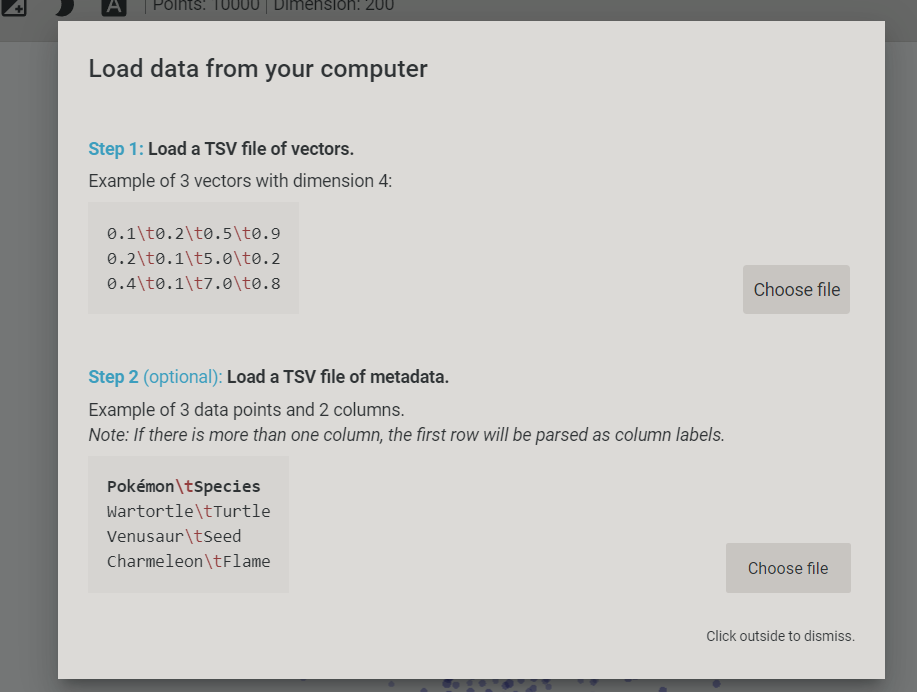

Looks pretty good!

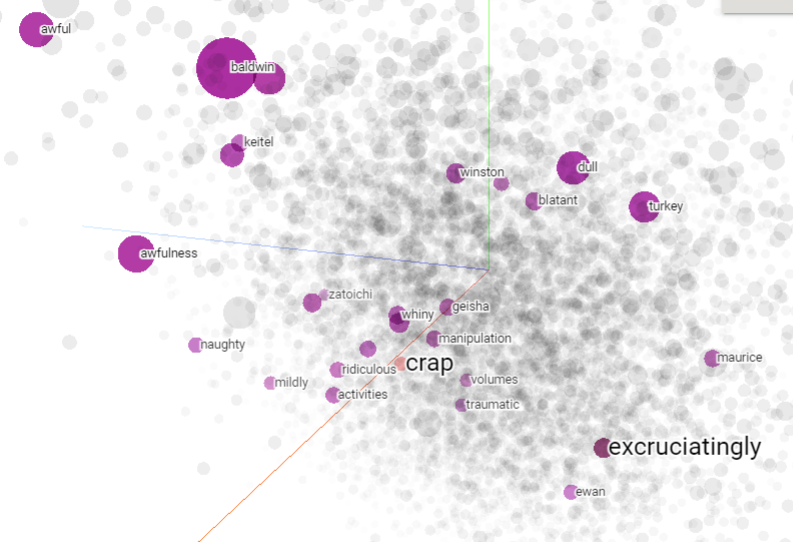